# IAEA OpenMC Basic Introduction Webinar
# August 13th, 2025

## Naming Conventions

Before we start working with the Python API, it's helpful to understand the naming convention of objects so that you can conceptualize what is a function, what is a class, etc. OpenMC's Python interface follows the same naming convention that is adopted by many/most Python projects:

- Module names are `lowercase`
- Functions are `lowercase_with_underscores`
- Classes are `CamelCase`
- Class attributes/variables are `lowercase_with_underscores`
- Top-level (global) variables are `UPPERCASE_WITH_UNDERSCORES`

To give a few specific examples:

- `openmc.deplete` is the depletion _module_
- `openmc.run` is a _function_
- `openmc.Material` is a _class_
- `openmc.data.ATOMIC_NUMBER` is a _top-level variable_

In [1]:
import openmc

# Materials

In [2]:
water = openmc.Material()

In [3]:
print(water)

Material
	ID             =	1
	Name           =	
	Temperature    =	None
	Density        =	None [sum]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       



In [4]:
water.name = 'moderator'

In [5]:
water.set_density('g/cc', 1.0)

In [6]:
water.add_nuclide('H1', 2.0)
water.add_element('O', 1.0)

In [7]:
print(water)

Material
	ID             =	1
	Name           =	moderator
	Temperature    =	None
	Density        =	1.0 [g/cc]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       
	H1             =	2.0          [ao]
	O16            =	0.999621     [ao]
	O17            =	0.000379     [ao]



In [8]:
water.add_s_alpha_beta('c_H_in_H2O')

In [9]:
print(water)

Material
	ID             =	1
	Name           =	moderator
	Temperature    =	None
	Density        =	1.0 [g/cc]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	S(a,b)         =	('c_H_in_H2O', 1.0)
	Nuclides       
	H1             =	2.0          [ao]
	O16            =	0.999621     [ao]
	O17            =	0.000379     [ao]



In [10]:
openmc.config['cross_sections']

PosixPath('/home/pshriwise/data/xs/openmc/endfb-vii.1-hdf5/cross_sections.xml')

In [11]:
import os
os.environ['OPENMC_CROSS_SECTIONS']

'/home/pshriwise/data/xs/openmc/endfb-vii.1-hdf5/cross_sections.xml'

In [12]:
zirconium = openmc.Material()
zirconium.name = 'cladding'
zirconium.set_density('g/cc', 6.6)
zirconium.add_element('Zr', 1.0)

In [13]:
print(zirconium)

Material
	ID             =	2
	Name           =	cladding
	Temperature    =	None
	Density        =	6.6 [g/cc]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       
	Zr90           =	0.5145       [ao]
	Zr91           =	0.1122       [ao]
	Zr92           =	0.1715       [ao]
	Zr94           =	0.1738       [ao]
	Zr96           =	0.028        [ao]



In [14]:
uo2 = openmc.Material()
uo2.name = 'fuel'
uo2.add_element('U', 1.0, enrichment=2.0)
uo2.add_element('O', 2.0)
uo2.set_density('g/cc', 10.0)

In [15]:
print(uo2)

Material
	ID             =	3
	Name           =	fuel
	Temperature    =	None
	Density        =	10.0 [g/cc]
	Volume         =	None [cm^3]
	Depletable     =	True
	S(a,b) Tables  
	Nuclides       
	U234           =	0.00018100268000368497 [ao]
	U235           =	0.020250596249671998 [ao]
	U238           =	0.9794756436128154 [ao]
	U236           =	9.275745750894252e-05 [ao]
	O16            =	1.999242     [ao]
	O17            =	0.000758     [ao]



In [16]:
materials = openmc.Materials([uo2, zirconium])
materials.append(water)

# Geometry

In [17]:
sphere = openmc.Sphere(r=1.0)

In [18]:
inside_sphere = -sphere
outside_sphere = +sphere

In [19]:
(10, 10, 10) in inside_sphere

False

In [20]:
(10, 10, 10) in outside_sphere

True

Everything works as expected! Now that we understand how to create half-spaces, we can create more complex volumes by combining half-spaces using Boolean operators:

- `&`: intersection
- `|`: union
- `~`: complement

For example, let's say we want to define a region that is the top part of the sphere (all points inside the sphere that have $z > 0$.

In [21]:
z_plane = openmc.ZPlane(0)
northern_hemisphere = -sphere & +z_plane

In [22]:
print(type(northern_hemisphere))

<class 'openmc.region.Intersection'>


In [23]:
northern_hemisphere.bounding_box

BoundingBox(lower_left=(-1.0, -1.0, 0.0), upper_right=(1.0, 1.0, 1.0))

<Axes: xlabel='x [cm]', ylabel='z [cm]'>

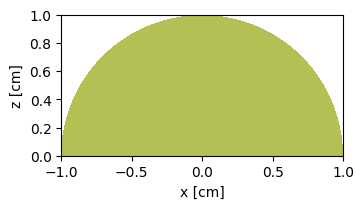

In [24]:
northern_hemisphere.plot(basis='xz')

In [25]:
another_sphere = openmc.Sphere(x0=5.0, r=1)

In [26]:
both_spheres = -sphere | -another_sphere

In [27]:
both_spheres.bounding_box

BoundingBox(lower_left=(-1.0, -1.0, -1.0), upper_right=(6.0, 1.0, 1.0))

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

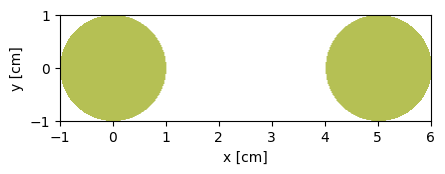

In [28]:
both_spheres.plot()

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

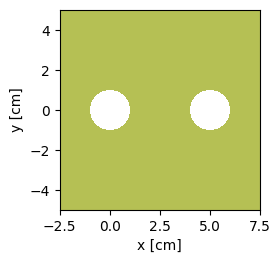

In [29]:
both_spheres = ~both_spheres
both_spheres.plot(origin=(2.5, 0, 0))

### Boundary Conditions

When you create a surface, by default particles that pass through the surface will consider it to be transmissive, i.e. they pass through the surface freely. To specify boundary conditions, you simply need to set the `Surface.boundary_type` to one of:

- `vacuum`
- `reflective`
- `periodic` (either rotational or translational)
- `white`

In [30]:
northern_hemisphere.boundary_type = 'vacuum'

## Pincell Geometry

In [31]:
fuel_outer_radius = openmc.ZCylinder(r=0.39)
clad_inner_radius = openmc.ZCylinder(r=0.40)
clad_outer_radius = openmc.ZCylinder(r=0.46)

In [32]:
fuel_region = -fuel_outer_radius
gap_region = +fuel_outer_radius & -clad_inner_radius
clad_region = +clad_inner_radius & -clad_outer_radius

In [33]:
fuel = openmc.Cell(name='fuel', fill=uo2, region=fuel_region)
gap = openmc.Cell(name='air gap', region=gap_region)
clad = openmc.Cell(name='clad', fill=zirconium, region=clad_region)

In [34]:
pitch = 1.26
left = openmc.XPlane(-pitch/2, boundary_type='reflective')
right = openmc.XPlane(pitch/2, boundary_type='reflective')
bottom = openmc.YPlane(-pitch/2, boundary_type='reflective')
top = openmc.YPlane(pitch/2, boundary_type='reflective')

In [35]:
water_region = +left & -right & +bottom & -top & +clad_outer_radius
moderator = openmc.Cell(name='moderator', fill=water, region=water_region)

In [36]:
root_universe = openmc.Universe(cells=[fuel, gap, clad, moderator])
geometry = openmc.Geometry(root_universe)

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

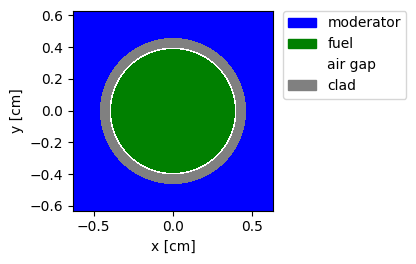

In [37]:
cell_colors = {moderator: 'blue',
               fuel: 'green',
               gap: 'white',
               clad:'grey'}

geometry.plot(colors=cell_colors, legend=True)

In [38]:
fuel.temperature = 300 # K
clad.temperature = 300 # K
moderator.temperature = 300 # K

# Execution

In [39]:
settings = openmc.Settings()
settings.particles = 10_000
settings.batches = 10
settings.inactive = 5

In [40]:
model = openmc.Model(geometry=geometry, settings=settings)

In [41]:
model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

PosixPath('/home/pshriwise/repos/iaea-webinar/solution/statepoint.10.h5')

# Tallies and Post-Processing

In [42]:
help(openmc.Model.__init__)

Help on function __init__ in module openmc.model.model:

__init__(self, geometry: 'openmc.Geometry | None' = None, materials: 'openmc.Materials' = None, settings: 'openmc.Settings | None' = None, tallies: 'openmc.Tallies | None' = None, plots: 'openmc.Plots | None' = None)
    Initialize self.  See help(type(self)) for accurate signature.



In [43]:
model.tallies

[]

In [44]:
heating_tally = openmc.Tally()
heating_tally.scores = ['heating']

In [45]:
heating_tally.mean

In [46]:
print(heating_tally)

Tally
	ID             =	1
	Name           =	
	Filters        =	
	Nuclides       =	
	Scores         =	['heating']
	Estimator      =	None
	Multiply dens. =	True


In [47]:
fission_tally = openmc.Tally()
fission_tally.scores = ['fission']

In [48]:
model.tallies = [heating_tally, fission_tally]

In [49]:
settings.photon_transport = True

In [50]:
statepoint_file = model.run(apply_tally_results=True)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [51]:
with openmc.StatePoint(statepoint_file) as sp:
    print(sp.tallies)

{np.int32(1): Tally
	ID             =	1
	Name           =	
	Filters        =	
	Nuclides       =	total
	Scores         =	['heating']
	Estimator      =	collision
	Multiply dens. =	True, np.int32(2): Tally
	ID             =	2
	Name           =	
	Filters        =	
	Nuclides       =	total
	Scores         =	['fission']
	Estimator      =	tracklength
	Multiply dens. =	True}


In [52]:
heating_tally.mean

array([[[1.03850966e+08]]])

In [53]:
fission_tally.mean

array([[[0.52193876]]])

In [54]:
mev_per_fission = 1e-6 *  heating_tally.mean.squeeze() / fission_tally.mean.squeeze()

In [55]:
print(f'MeV per fission: {mev_per_fission:.3f}')

MeV per fission: 198.972


In [56]:
reaction_tally = openmc.Tally()
material_filter = openmc.MaterialFilter([uo2, zirconium, water])
reaction_tally.filters = [material_filter]
reaction_tally.scores = ['absorption', 'fission', 'scatter']

In [57]:
model.tallies = [reaction_tally]

In [ ]:
statepoint_file = model.run(apply_tally_results=True)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [ ]:
dataframe = reaction_tally.get_pandas_dataframe()

In [ ]:
dataframe

In [ ]:
for material in materials:
    dataframe.loc[dataframe['material'] == material.id, 'material name'] = material.name

In [ ]:
dataframe

In [ ]:
fission_df = dataframe[dataframe['score'] == 'fission']
scatter_df = dataframe[dataframe['score'] == 'scatter']
absorption_df = dataframe[dataframe['score'] == 'absorption']

In [ ]:
absorption_df.plot('material name', 'mean', kind='bar', ylabel='absorptions/src-particle')